In [ ]:
file_path = r'C:\Users\sneha\Downloads\cps_00006.csv.gz' # path for the data, needs to be changed accordingly

In [ ]:
num_of_states = 50     # this needs be changed to the desired number of states

In [7]:
import pandas as pd
import numpy as np
import gzip

# data preperation code


def cps_data(file_path):
  
    df = pd.read_csv(file_path, compression='gzip', header=0) # importing the data

    
    df = df[(df['INCWAGE'] != 99999999) & (df['INCWAGE'] != 0) & (df['INCWAGE'] != 999)]  # dropping the rows containing invalid and 0 INCWAGE according to the labels

    df['INCWAGE'] = np.log(df['INCWAGE'])  # taking log of weekly earnings which will be our dependent variable in the regressions


    df = df[(df['EDUC'] != 0) & (df['EDUC'] != 1)]  # dropping education levels 0 and 1 as they are invalid entries as per the labels of the dataset

    df = df[(df['YEAR'] >= 1980) & (df['YEAR'] <= 2000)]  # taking the time frame from 1980 to 2000

    def categorize_education(educ_code): # creating a fucntion to categorize education levels
        if educ_code <= 10:
            return 'Up to Grade 10'
        elif 10 < educ_code <= 70:
            return 'High School'
        elif 70 < educ_code <= 123:
            return "Master's Degree"
        else:
            return 'Doctorate Degree'

    
    df['Education_Category'] = df['EDUC'].apply(categorize_education) # applying the function to create a new 'Education_Category' column

    df = pd.get_dummies(df, columns=['Education_Category'], prefix='', prefix_sep='', drop_first=True)

    boolean = ['Up to Grade 10', 'High School', "Master's Degree"]
    df[boolean] = df[boolean].astype(int)

    df = df[~((df['STATEFIP'] > 56) | (df['STATEFIP'] == 11))]  # taking only the 50 states of the States and exclusing the regions as per the labels of the dataset

    df = df[(df['AGE'] >= 25) & (df['AGE'] <= 50)]  # taking the age group from 25 to 50

    df = df[df['SEX'] == 2] # taking only female respondents

    return df

In [12]:

import statsmodels.api as sm

# data aggregation code

def process_cps_data(file_path):

    df = cps_data(file_path)

    X = df[['High School', "Master's Degree", 'Up to Grade 10', 'AGE']] # the covariates used 1st stage of data aggregation
    y = df['INCWAGE']

    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()

    y_pred = model.predict(X)  # obtaining the predicted values of the model

    residuals = y - y_pred

    df['Residuals'] = residuals

    residuals_mean_by_state_year = df.groupby(['STATEFIP', 'YEAR'])['Residuals'].mean().reset_index()

    residuals_mean_by_state_year 

    return residuals_mean_by_state_year

Number of times null hypothesis is rejected: 1 out of 5 simulations
Type 1 Error: 0.2
Bias for Coefficient of Treatment : 0.002967237594660002
MSE for Coefficient of Treatment : 0.003127615910135432
RMSE for Coefficient of Treatment : 0.0559250919546444
Average Standard Error: 0.020157322038518145
Standard Error of the beta_1 distribution: 0.034635422444833294
The confidence interval is (-0.06491819039721326, {0.07085266558653326})


c:\Users\sneha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


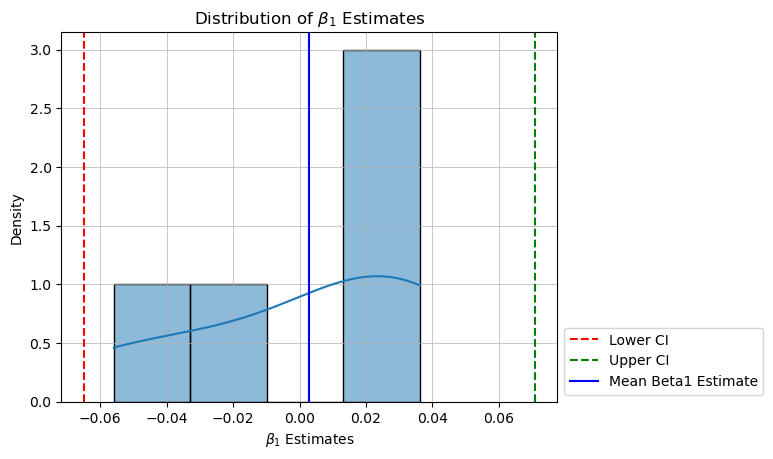

In [11]:

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


alpha = 0.05  # Significance level
num_simulations = 5


reject_count = 0  # Counter for the number of rejections
true_beta1_value = 0   # Initialising the counters
bias_values = []
squared_error_values = []
standard_error_values =[]
beta1_estimates = []


np.random.seed(42) # setting seed for reproducibility

df = process_cps_data(file_path)  # importing the processed and aggregated data

for _ in range(num_simulations):

    data = df.copy()

    unique_statefips = data['STATEFIP'].unique()
    selected_statefips = np.random.choice(unique_statefips, size=num_of_states, replace=False)

    # Filter the DataFrame to only include rows with the selected STATEFIPs
    data = data[data['STATEFIP'].isin(selected_statefips)]
    
    states = data['STATEFIP'].unique()
    
    # Randomly selecting  half of the states to be in the treatment group
    
    treatment_states = np.random.choice(states, size=len(states)//2, replace=False)

    # Assigning treatment year to each treatment state, staggered between 1985 and 1995

    treatment_years = np.random.choice(range(1985, 1995), size=len(treatment_states), replace=True)
    state_to_treatment_year = dict(zip(treatment_states, treatment_years))

    # Adding a treatment column to the DataFrame

    data['TREATMENT'] = data.apply(lambda x: 1 if x['STATEFIP'] in treatment_states and x['YEAR'] >= state_to_treatment_year[x['STATEFIP']] else 0, axis=1)
  
    dummy_df = pd.get_dummies(data['STATEFIP'], prefix='STATEFIP', drop_first=True).astype(int)

    # Concatenate the dummy variables with the original DataFrame
    data = pd.concat([data, dummy_df], axis=1)

    dummy_df2 = pd.get_dummies(data['YEAR'], prefix='YEAR', drop_first=True).astype(int)

    # Concatenate the dummy variables with the original DataFrame
    data = pd.concat([data, dummy_df2], axis=1)

    columns_to_exclude = ['STATEFIP', 'YEAR', 'Residuals']

    X_columns =[col for col in data.columns if col not in columns_to_exclude]

    X = data[X_columns]

    X = sm.add_constant(X)
    Y = data['Residuals'] 
    model = sm.OLS(Y, X).fit()

    bias_value = model.params['TREATMENT'] - true_beta1_value
    
    bias_values.append(bias_value)

    squared_error = (model.params['TREATMENT'] - true_beta1_value) ** 2

    
    standard_error = model.bse['TREATMENT']
    standard_error_values.append(standard_error)
    beta1_estimates.append(model.params['TREATMENT'])
    
    
    # Checking if null hypothesis for beta1 is rejected

    if model.pvalues['TREATMENT'] < alpha :
        reject_count += 1


type1_error = reject_count / num_simulations

bias = np.mean(bias_values)
mse = np.mean(squared_error)   
rmse = np.sqrt(mse)  
average_standard_error = np.mean(standard_error_values)   
std_error_beta_distribution = np.std(beta1_estimates)

confidence_interval = (
    np.mean(beta1_estimates) - 1.96 * std_error_beta_distribution,
    np.mean(beta1_estimates) + 1.96 * std_error_beta_distribution
)


print(f"Number of times null hypothesis is rejected: {reject_count} out of {num_simulations} simulations")
print(f"Type 1 Error: {type1_error}")
print(f"Bias for Coefficient of Treatment : {bias}")
print(f"MSE for Coefficient of Treatment : {mse}")
print(f"RMSE for Coefficient of Treatment : {rmse}")
print(f"Average Standard Error: {average_standard_error}")
print(f"Standard Error of the beta_1 distribution: {std_error_beta_distribution}")
print(f'The confidence interval is {confidence_interval[0] , {confidence_interval[1]}}')

sns.histplot(beta1_estimates, kde = True)
plt.xlabel(r'$\beta_1$ Estimates')  
plt.ylabel('Density')
plt.title(r'Distribution of $\beta_1$ Estimates')


mean_beta1_estimate = np.mean(beta1_estimates) # Calculating mean of beta1 estimates for marking on plot

# Adding vertical lines for the confidence interval and the mean beta1 estimate

plt.axvline(x=confidence_interval[0], color='red', linestyle='--', label='Lower CI')
plt.axvline(x=confidence_interval[1], color='green', linestyle='--', label='Upper CI')
plt.axvline(x=mean_beta1_estimate, color='blue', linestyle='-', label='Mean Beta1 Estimate')

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))

plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.show()





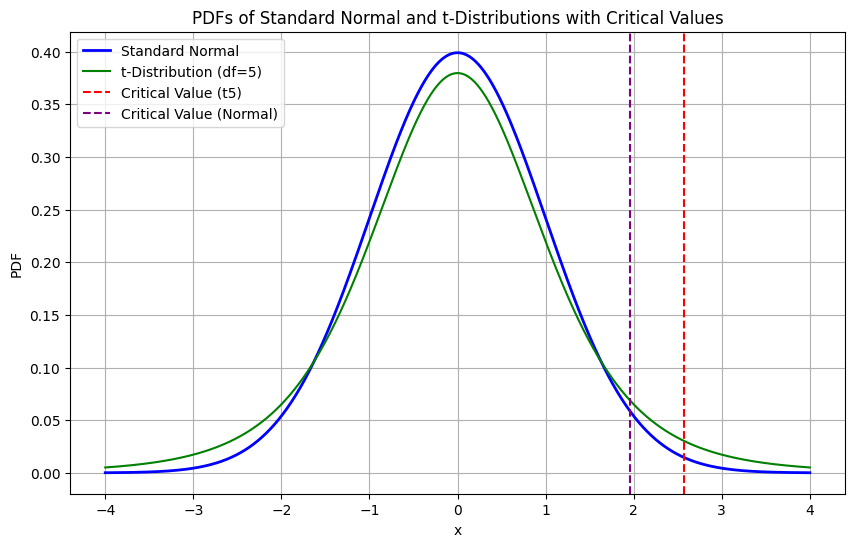

In [43]:
# to draw a N(0,1) distribution and t_5 distribution

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t

# Define the range of x values
x = np.linspace(-4, 4, 1000)

# Calculate the PDFs for different distributions
pdf_standard_normal = norm.pdf(x)
pdf_t5 = t.pdf(x, df=5)

# Define the desired confidence level (e.g., 95%)
confidence_level = 0.95

# Calculate the critical values for t5 and standard normal distributions
critical_value_t5 = t.ppf(1 - (1 - confidence_level) / 2, df=5)
critical_value_normal = norm.ppf(1 - (1 - confidence_level) / 2)

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(x, pdf_standard_normal, label='Standard Normal', linewidth=2, color='blue')
plt.plot(x, pdf_t5, label='t-Distribution (df=5)', color='green')

# Add vertical lines for critical values
plt.axvline(x=critical_value_t5, color='red', linestyle='--', label='Critical Value (t5)')
plt.axvline(x=critical_value_normal, color='purple', linestyle='--', label='Critical Value (Normal)')

# Customize the plot
plt.title('PDFs of Standard Normal and t-Distributions with Critical Values')
plt.xlabel('x')
plt.ylabel('PDF')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
